In [58]:
import os
import torch
import matplotlib.pyplot as plt

from bmadx.beam_generator import create_beam

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

In [59]:
data_dir = 'data'

In [60]:
# create synthetic ground truth beam from base and transform yaml files
gt_beam = create_beam(base_yaml = os.path.join(data_dir,'base.yaml'),
                      transforms_yaml = os.path.join(data_dir,'transforms.yaml'), 
                      p0c = 10.0e6,
                      save_as = os.path.join('data', 'gt_beam.pt'))

ground truth distribution saved at data/gt_beam.pt


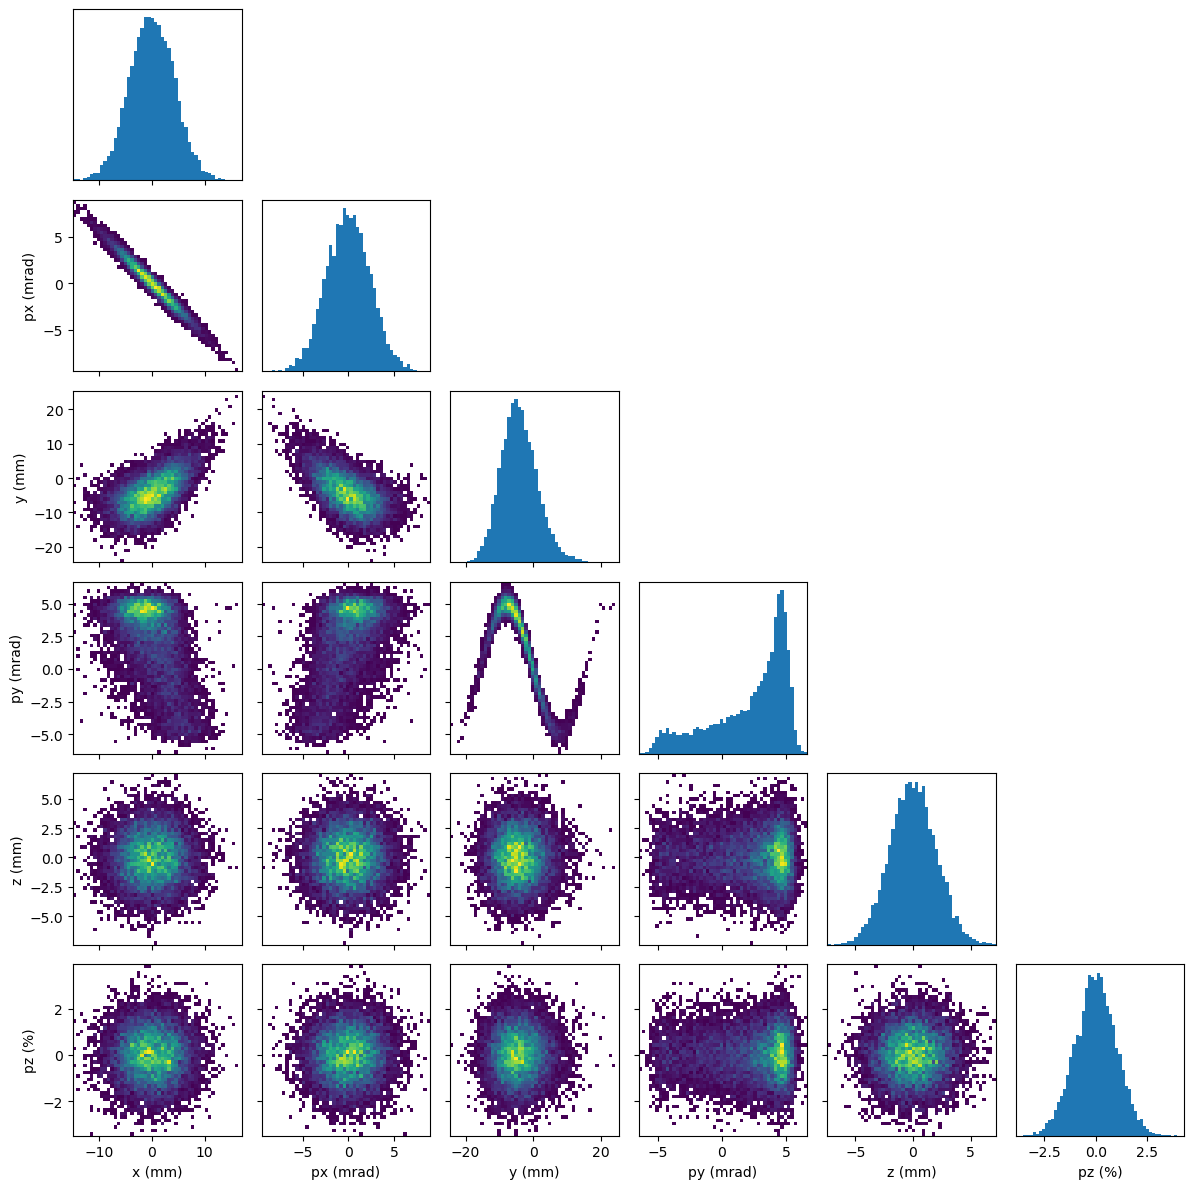

In [61]:
# plot synthetic ground truth beam projections 
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()

In [62]:
# diagnostic beamline:
lattice = quad_drift()

# design momentum (eV)
p0c = 10.0e6

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-25, 15, n_ks).reshape((n_ks,1,1))

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen: 
bins = torch.linspace(-30, 30, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

/Users/samuelbarber/PS_Reconstruction/phase_space_reconstruction/phase_space_reconstruction/diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


In [6]:
# generate and save train and test datasets
train_dset = run_quad_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data', 'train.dset'))
test_dset = run_quad_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test.dset'))

dataset saved as 'data/train.dset'
dataset saved as 'data/test.dset'


image size = 60 x 60 mm
test samples boxed in orange


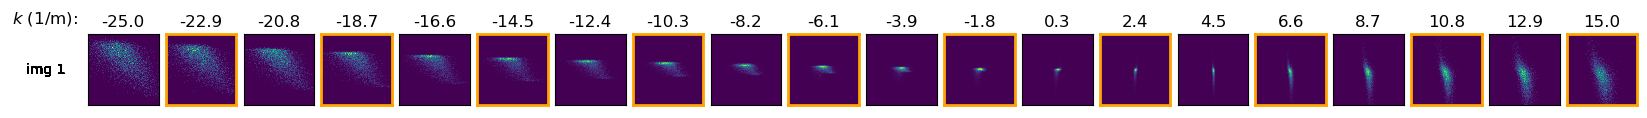

In [7]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
plt.show()

In [10]:
# training
pred_beam = train_1d_scan(train_dset, lattice, p0c, screen, n_epochs=500)

Using device: cpu


/Users/samuelbarber/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_64sp5n4yln/croot/pytorch_1669252639708/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4634621.5000, grad_fn=<MulBackward0>)
100 tensor(1099212.1250, grad_fn=<MulBackward0>)
200 tensor(1091101.2500, grad_fn=<MulBackward0>)
300 tensor(1059212.7500, grad_fn=<MulBackward0>)
400 tensor(1068230.2500, grad_fn=<MulBackward0>)


In [11]:
# predicted screens:
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 60 x 60 mm
test samples boxed in orange


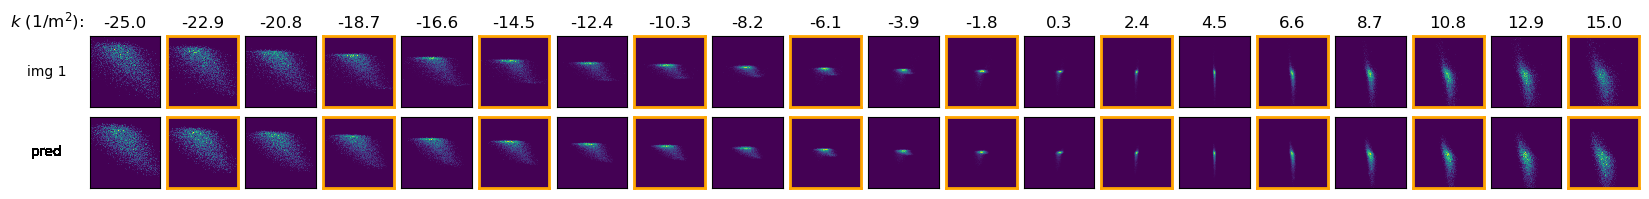

In [12]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins, bins)
plt.show()

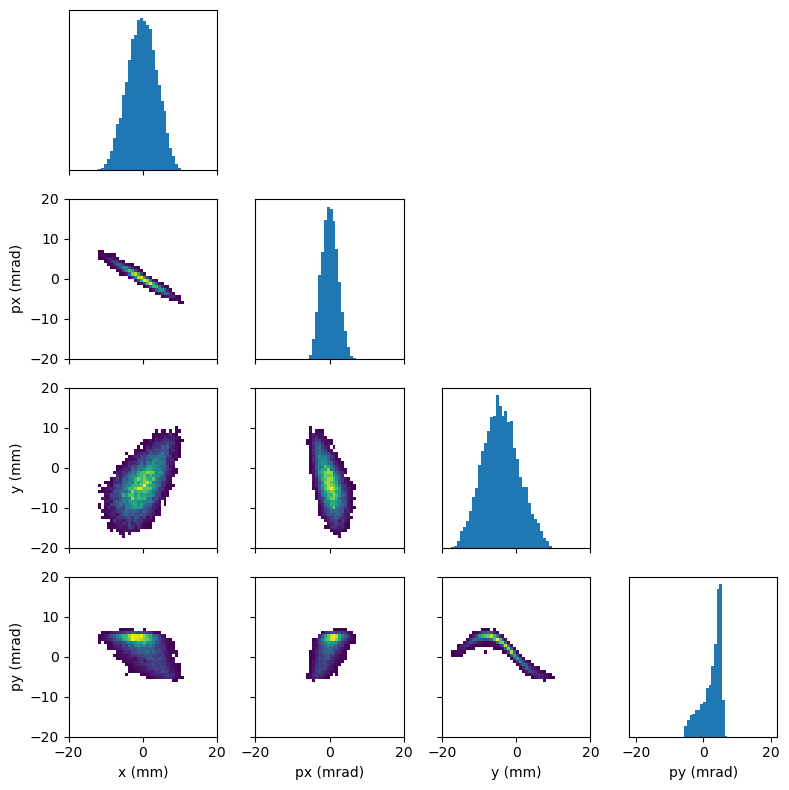

In [13]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=('x', 'px', 'y', 'py'),
                           same_lims=True,
                           custom_lims=[-20e-3,20e-3]
                           )
plt.show()

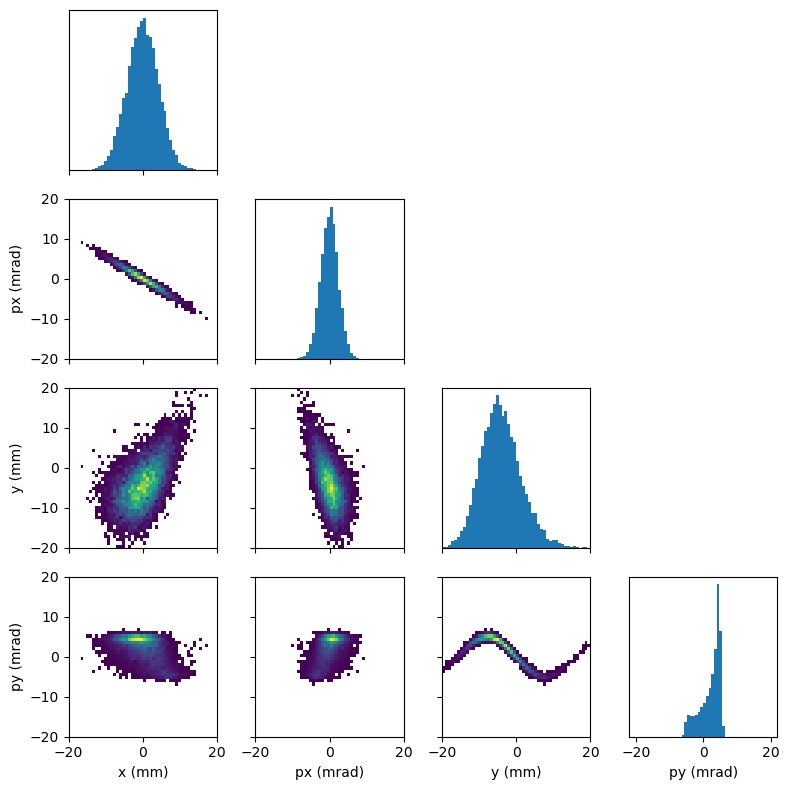

In [14]:
# ground truth beam projections:
fig, ax = plot_projections(gt_beam.numpy_particles(),
                           coords=('x', 'px', 'y', 'py'),
                           same_lims=True,
                           custom_lims = [-20e-3, 20e-3]
                           )
plt.show()

In [13]:
torch.cuda.empty_cache()

In [57]:
train_dset.images.size()


torch.Size([10, 1, 200, 200])

In [21]:
bins

tensor([-0.0300, -0.0297, -0.0294, -0.0291, -0.0288, -0.0285, -0.0282, -0.0279,
        -0.0276, -0.0273, -0.0270, -0.0267, -0.0264, -0.0261, -0.0258, -0.0255,
        -0.0252, -0.0249, -0.0246, -0.0243, -0.0240, -0.0237, -0.0234, -0.0231,
        -0.0228, -0.0225, -0.0222, -0.0219, -0.0216, -0.0213, -0.0210, -0.0207,
        -0.0204, -0.0201, -0.0197, -0.0194, -0.0191, -0.0188, -0.0185, -0.0182,
        -0.0179, -0.0176, -0.0173, -0.0170, -0.0167, -0.0164, -0.0161, -0.0158,
        -0.0155, -0.0152, -0.0149, -0.0146, -0.0143, -0.0140, -0.0137, -0.0134,
        -0.0131, -0.0128, -0.0125, -0.0122, -0.0119, -0.0116, -0.0113, -0.0110,
        -0.0107, -0.0104, -0.0101, -0.0098, -0.0095, -0.0092, -0.0089, -0.0086,
        -0.0083, -0.0080, -0.0077, -0.0074, -0.0071, -0.0068, -0.0065, -0.0062,
        -0.0059, -0.0056, -0.0053, -0.0050, -0.0047, -0.0044, -0.0041, -0.0038,
        -0.0035, -0.0032, -0.0029, -0.0026, -0.0023, -0.0020, -0.0017, -0.0014,
        -0.0011, -0.0008, -0.0005, -0.00

In [22]:
ks

tensor([[[-25.0000]],

        [[-22.8947]],

        [[-20.7895]],

        [[-18.6842]],

        [[-16.5789]],

        [[-14.4737]],

        [[-12.3684]],

        [[-10.2632]],

        [[ -8.1579]],

        [[ -6.0526]],

        [[ -3.9474]],

        [[ -1.8421]],

        [[  0.2632]],

        [[  2.3684]],

        [[  4.4737]],

        [[  6.5789]],

        [[  8.6842]],

        [[ 10.7895]],

        [[ 12.8947]],

        [[ 15.0000]]])

In [27]:
ks[::2]


tensor([[[-25.0000]],

        [[-20.7895]],

        [[-16.5789]],

        [[-12.3684]],

        [[ -8.1579]],

        [[ -3.9474]],

        [[  0.2632]],

        [[  4.4737]],

        [[  8.6842]],

        [[ 12.8947]]])

In [28]:
ks[1::2]

tensor([[[-22.8947]],

        [[-18.6842]],

        [[-14.4737]],

        [[-10.2632]],

        [[ -6.0526]],

        [[ -1.8421]],

        [[  2.3684]],

        [[  6.5789]],

        [[ 10.7895]],

        [[ 15.0000]]])

In [53]:
train_dset.images[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [66]:
train_ks = ks[::2]
train_ks

tensor([[[-25.0000]],

        [[-20.7895]],

        [[-16.5789]],

        [[-12.3684]],

        [[ -8.1579]],

        [[ -3.9474]],

        [[  0.2632]],

        [[  4.4737]],

        [[  8.6842]],

        [[ 12.8947]]])